# Financial Data Integration and Preprocessing Pipeline

This notebook implements a comprehensive data integration pipeline for financial market analysis, combining multiple asset classes and economic indicators into a unified dataset.

## Data Pipeline Setup

The initial setup establishes necessary dependencies and configures logging mechanisms. Key libraries include:
- `pandas`: For efficient data manipulation and analysis
- `seaborn` & `matplotlib`: For potential visualization needs
- `logging`: For tracking pipeline execution and debugging

The logging configuration ensures both file-based and console output for complete operational transparency.

In [2]:
import os
import pandas as pd
import logging
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML
%matplotlib inline

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s [%(levelname)s] %(message)s',
    handlers=[
        logging.FileHandler("merge_data.log"),
        logging.StreamHandler()
    ]
)

print("Libraries imported successfully!")

Libraries imported successfully!


## Data Source Configuration

Defines the architecture for our multi-source financial data integration:

1. **Market Securities**:
   - Stocks: Major tech companies (MSFT, AMZN, GOOGL, TSLA)
   - ETFs: Broad market and sector-specific funds
   - Market Indices: Key benchmark indicators

2. **Alternative Assets**:
   - Bonds: Treasury yields and bond ETFs
   - Commodities: Gold, Oil, Silver futures
   - REITs: Real estate investment vehicles
   - Cryptocurrencies: Major digital assets

3. **Economic Indicators**:
   - FRED data: GDP, CPI, Federal Funds Rate, Unemployment, PPI

In [3]:
# Initialize paths
eda_data_path = 'data/raw'
output_path = 'data/processed'

# Define data categories
data_categories = {
    'stock': (['MSFT', 'AMZN', 'GOOGL', 'TSLA'], 'yahoo'),
    'etf': (['SPY', 'QQQ', 'XLK', 'XLV', 'XLF'], 'yahoo'),
    'index': (['^GSPC', '^IXIC', '^DJI', '^RUT'], 'yahoo'),
    'bond': (['^TNX', 'IEF', 'TLT'], 'yahoo'),
    'commodity': (['GC=F', 'CL=F', 'SI=F'], 'yahoo'),
    'reit': (['VNQ', 'SCHH', 'IYR'], 'reits'),
    'crypto': (['BTC', 'ETH', 'LTC'], 'crypto'),
    'fred': (['GDP', 'CPIAUCSL', 'FEDFUNDS', 'UNRATE', 'PPIACO'], 'fred')
}

print(f"Data paths initialized:\n- Input: {eda_data_path}\n- Output: {output_path}")

Data paths initialized:
- Input: data/raw
- Output: data/processed


## Data Loading Implementation

The `load_data` function implements a robust data ingestion process with:
- Dynamic path handling for different data categories
- Error handling for missing or corrupted files
- Progress tracking and load statistics
- Specialized parsing for different data sources (FRED vs market data)

This ensures reliable data loading while maintaining data integrity and providing operational visibility.

In [4]:
def load_data(data_categories, eda_data_path):
    total_loaded = 0
    failed_loads = 0
    loaded_data = {}
    
    print("\nData Loading Progress:")
    for category, (items, subfolder) in data_categories.items():
        loaded_data[f'{category}_data'] = {}
        folder_path = os.path.join(eda_data_path, subfolder)
        
        for item in items:
            file_path = os.path.join(folder_path, f'{item}.csv')
            try:
                if category == 'fred':
                    loaded_data[f'{category}_data'][item] = pd.read_csv(file_path, index_col=0, parse_dates=True)
                else:
                    loaded_data[f'{category}_data'][item] = pd.read_csv(file_path, parse_dates=['Date'])
                total_loaded += 1
                print(f"Loaded {item}")
            except FileNotFoundError:
                print(f"File not found: {file_path}")
                loaded_data[f'{category}_data'][item] = pd.DataFrame()
                failed_loads += 1
            except Exception as e:
                print(f"Error loading {item}: {str(e)}")
                loaded_data[f'{category}_data'][item] = pd.DataFrame()
                failed_loads += 1
    
    print(f"\nLoading Statistics:")
    print(f"Successfully loaded: {total_loaded}")
    print(f"Failed: {failed_loads}")
    
    return loaded_data

# Load the data
loaded_data = load_data(data_categories, eda_data_path)


Data Loading Progress:
Loaded MSFT
Loaded AMZN
Loaded GOOGL
Loaded TSLA
Loaded SPY
Loaded QQQ
Loaded XLK
Loaded XLV
Loaded XLF
Loaded ^GSPC
Loaded ^IXIC
Loaded ^DJI
Loaded ^RUT
Loaded ^TNX
Loaded IEF
Loaded TLT
Loaded GC=F
Loaded CL=F
Loaded SI=F
Loaded VNQ
Loaded SCHH
Loaded IYR
Loaded BTC
Loaded ETH
Loaded LTC
Loaded GDP
Loaded CPIAUCSL
Loaded FEDFUNDS
Loaded UNRATE
Loaded PPIACO

Loading Statistics:
Successfully loaded: 30
Failed: 0


## Data Integration Process

The `merge_data` function performs sophisticated data harmonization:
- Creates a continuous daily date index (2010-2023)
- Implements intelligent joining strategies for different asset classes
- Handles varying data structures (e.g., crypto vs traditional assets)
- Applies appropriate data cleaning techniques:
  - Forward-filling for trading gaps
  - Backward-filling for historical completeness
  - Removal of inconsistent records

In [5]:
def merge_data(loaded_data):
    print("Starting data merge process...")
    
    df = pd.DataFrame(index=pd.date_range(start='2010-01-01', end='2023-12-31', freq='D'))
    
    # merge all categories
    for category in ['stock', 'etf', 'index', 'bond', 'commodity', 'reit']:
        data_dict = loaded_data[f'{category}_data']
        for item, item_df in data_dict.items():
            if not item_df.empty:
                df = df.join(item_df.set_index('Date')['Close'], how='left')
                df.rename(columns={'Close': f'{item}_Close'}, inplace=True)
                print(f"Merged {item}")
    
    # handle crypto separately
    for crypto, crypto_df in loaded_data['crypto_data'].items():
        if not crypto_df.empty:
            df = df.join(crypto_df.set_index('Date')['Price_Close'], how='left')
            df.rename(columns={'Price_Close': f'{crypto}_Close'}, inplace=True)
            print(f"Merged {crypto}")
    
    # handle fred data
    for indicator, indicator_df in loaded_data['fred_data'].items():
        if not indicator_df.empty:
            df = df.join(indicator_df, how='left')
            print(f"Merged {indicator}")
    
    print("\nCleaning data...")
    df.ffill(inplace=True)
    df.bfill(inplace=True)
    df.dropna(inplace=True)
    
    merged_data = df.reset_index().rename(columns={'index': 'Date'})
    print(f"Final dataset shape: {merged_data.shape}")
    
    # display sample
    display(HTML("<h3>Sample of Merged Data:</h3>"))
    display(merged_data.head())
    
    return merged_data

# Merge the data
merged_data = merge_data(loaded_data)

Starting data merge process...
Merged MSFT
Merged AMZN
Merged GOOGL
Merged TSLA
Merged SPY
Merged QQQ
Merged XLK
Merged XLV
Merged XLF
Merged ^GSPC
Merged ^IXIC
Merged ^DJI
Merged ^RUT
Merged ^TNX
Merged IEF
Merged TLT
Merged GC=F
Merged CL=F
Merged SI=F
Merged VNQ
Merged SCHH
Merged IYR
Merged BTC
Merged ETH
Merged LTC
Merged GDP
Merged CPIAUCSL
Merged FEDFUNDS
Merged UNRATE
Merged PPIACO

Cleaning data...
Final dataset shape: (5113, 31)


,Date,MSFT_Close,AMZN_Close,GOOGL_Close,TSLA_Close,SPY_Close,QQQ_Close,XLK_Close,XLV_Close,XLF_Close,...,SCHH_Close,IYR_Close,BTC_Close,ETH_Close,LTC_Close,GDP,CPI,FEDFUNDS,UNRATE,PPI
0,2010-01-01,30.950001,6.6950,15.684434,1.592667,113.330002,46.419998,23.27,31.610001,11.933387,...,12.58,45.810001,457.334015,320.884003,5.05855,14764.61,217.488,0.11,9.8,181.9
1,2010-01-02,30.950001,6.6950,15.684434,1.592667,113.330002,46.419998,23.27,31.610001,11.933387,...,12.58,45.810001,457.334015,320.884003,5.05855,14764.61,217.488,0.11,9.8,181.9
2,2010-01-03,30.950001,6.6950,15.684434,1.592667,113.330002,46.419998,23.27,31.610001,11.933387,...,12.58,45.810001,457.334015,320.884003,5.05855,14764.61,217.488,0.11,9.8,181.9
3,2010-01-04,30.950001,6.6950,15.684434,1.592667,113.330002,46.419998,23.27,31.610001,11.933387,...,12.58,45.810001,457.334015,320.884003,5.05855,14764.61,217.488,0.11,9.8,181.9
4,2010-01-05,30.959999,6.7345,15.615365,1.592667,113.629997,46.419998,23.24,31.299999,12.152721,...,12.58,45.919998,457.334015,320.884003,5.05855,14764.61,217.488,0.11,9.8,181.9


## Data Persistence

Final stage of the pipeline implementing:
- Structured output organization
- CSV format persistence for universal compatibility
- Directory handling with error prevention
- Verification of successful data storage

This ensures that the integrated dataset is properly preserved for subsequent analysis phases.

In [6]:
def save_merged_data(merged_data, output_path):
    os.makedirs(output_path, exist_ok=True)
    output_file = os.path.join(output_path, 'merged_data.csv')
    merged_data.to_csv(output_file, index=False)
    print(f"Merged data saved to: {output_file}")

# Save the merged data
save_merged_data(merged_data, output_path)

Merged data saved to: data/processed\merged_data.csv


## Data Quality Visualization

The following plots provide visual verification of the data integration process:
1. Data Availability Heatmap: Visualizes missing data patterns
2. Time Series Coverage: Shows the temporal span of different data sources
3. Sample Size Statistics: Displays the completeness of each data category

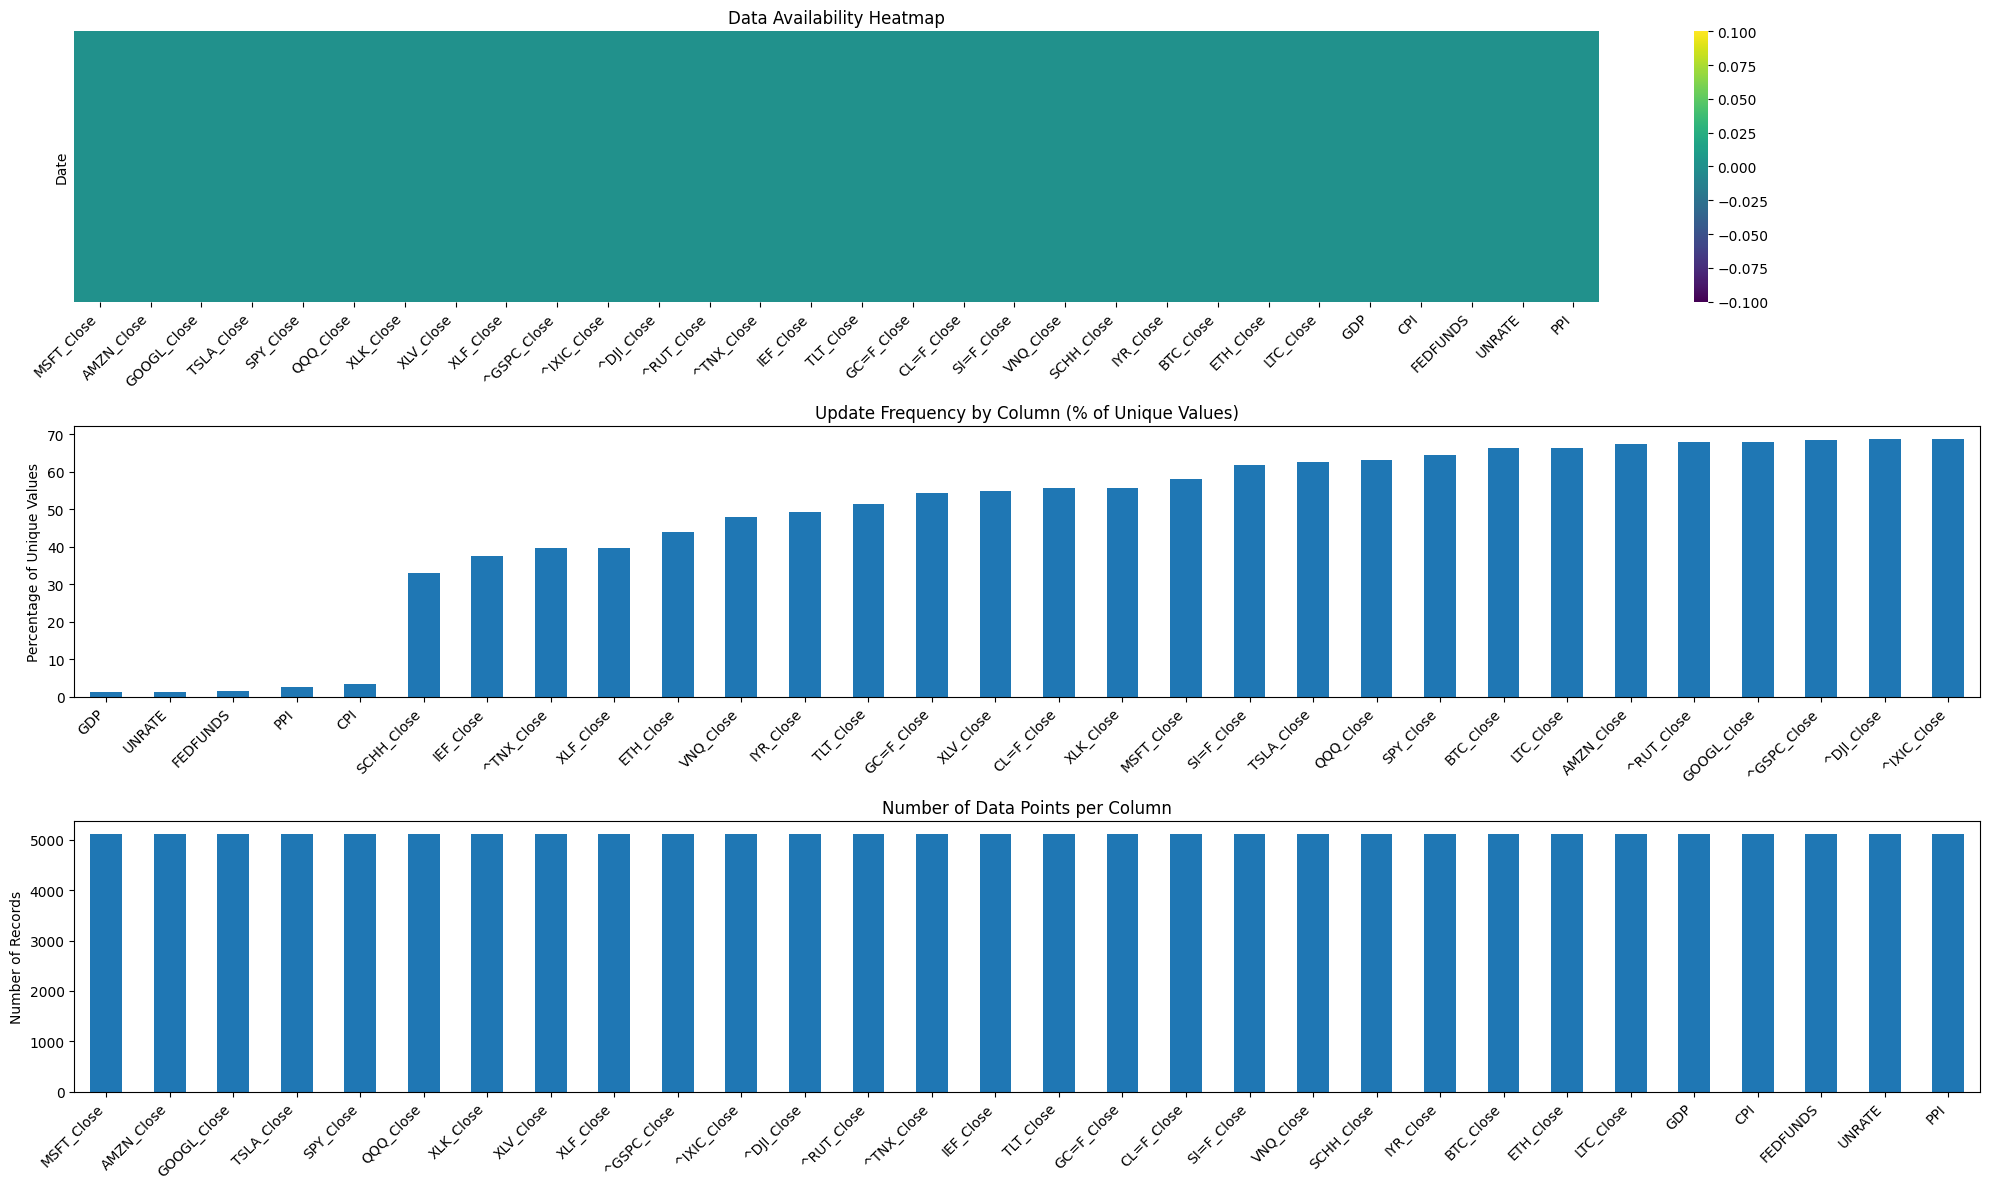


Dataset Summary:
Time Range: 2010-01-01 00:00:00 to 2023-12-31 00:00:00
Total Days: 5,113
Total Features: 30

Update Frequency:
MSFT_Close: 2,966 unique values out of 5,113 records (58.0% unique)
AMZN_Close: 3,448 unique values out of 5,113 records (67.4% unique)
GOOGL_Close: 3,476 unique values out of 5,113 records (68.0% unique)
TSLA_Close: 3,203 unique values out of 5,113 records (62.6% unique)
SPY_Close: 3,300 unique values out of 5,113 records (64.5% unique)
QQQ_Close: 3,232 unique values out of 5,113 records (63.2% unique)
XLK_Close: 2,850 unique values out of 5,113 records (55.7% unique)
XLV_Close: 2,808 unique values out of 5,113 records (54.9% unique)
XLF_Close: 2,032 unique values out of 5,113 records (39.7% unique)
^GSPC_Close: 3,504 unique values out of 5,113 records (68.5% unique)
^IXIC_Close: 3,509 unique values out of 5,113 records (68.6% unique)
^DJI_Close: 3,507 unique values out of 5,113 records (68.6% unique)
^RUT_Close: 3,471 unique values out of 5,113 records (67.

In [9]:
def plot_data_quality(merged_data):
    fig = plt.figure(figsize=(20, 12))
    
    # 1. Missing Data Heatmap (more readable)
    plt.subplot(3, 1, 1)
    missing_data = merged_data.isnull()
    sns.heatmap(missing_data, 
                yticklabels=False,
                xticklabels=True,
                cmap='viridis')
    plt.title('Data Availability Heatmap')
    plt.xticks(rotation=45, ha='right')
    
    # 2. Update Frequency Analysis
    plt.subplot(3, 1, 2)
    unique_values = merged_data.apply(lambda x: (x.nunique() / len(x)) * 100)
    unique_values.sort_values(ascending=True).plot(kind='bar')
    plt.title('Update Frequency by Column (% of Unique Values)')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Percentage of Unique Values')
    
    # 3. Time Series Coverage
    plt.subplot(3, 1, 3)
    data_points = merged_data.count()
    data_points.sort_values(ascending=True).plot(kind='bar')
    plt.title('Number of Data Points per Column')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Number of Records')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nDataset Summary:")
    print(f"Time Range: {merged_data.index.min()} to {merged_data.index.max()}")
    print(f"Total Days: {len(merged_data):,}")
    print(f"Total Features: {len(merged_data.columns):,}")
    
    # Data frequency analysis
    print("\nUpdate Frequency:")
    for col in merged_data.columns:
        unique_count = merged_data[col].nunique()
        total_count = merged_data[col].count()
        print(f"{col}: {unique_count:,} unique values out of {total_count:,} records " + 
              f"({(unique_count/total_count)*100:.1f}% unique)")

# Convert Date to index if it's not already
if 'Date' in merged_data.columns:
    merged_data = merged_data.set_index('Date')

# Generate quality assurance plots
plot_data_quality(merged_data)

## Pipeline Summary

This data integration pipeline successfully:
1. Consolidates multiple financial data sources
2. Harmonizes different data structures and frequencies
3. Handles missing data and inconsistencies
4. Produces a clean, analysis-ready dataset
5. Maintains complete operational logging

The resulting dataset provides a comprehensive foundation for subsequent financial analysis and modeling stages.